In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# -------- 1. Load & Preprocess Data --------
file_path = "/content/Grocery_Sales.csv"
df = pd.read_csv(file_path)

# Drop unnecessary column
df.drop(columns=["Unnamed: 0", "transaction_id", "product_id"], errors="ignore", inplace=True)

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Process timestamp column
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df.drop(columns=["timestamp"], inplace=True)  # Drop raw timestamp

# Encode categorical columns
categorical_cols = ["customer_type", "category", "payment_type"]
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Normalize numerical columns
scaler = MinMaxScaler()
num_cols = ["unit_price", "total", "year", "month", "day", "hour", "weekday"]
df[num_cols] = scaler.fit_transform(df[num_cols])

# Split dataset into features and target
X = df.drop(columns=["quantity"])  # Features
y = df["quantity"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------- 2. Train Optimized Random Forest Model --------
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.9,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
rf_preds = rf_model.predict(X_test)

# -------- 3. Evaluate Model --------
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    accuracy = 1 - (mae / np.mean(y_true))  # Approximate accuracy calculation
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}, Accuracy: {accuracy:.4f}")
    return mae, mse, r2, accuracy

rf_metrics = evaluate_model(y_test, rf_preds, "Optimized Random Forest")

# -------- 4. Visualize Results --------

# Extract hour properly before scaling
df["hour"] = df["timestamp"].dt.hour  # Ensure it's in 0-23 range

# Normalize only relevant numerical columns
scaler = MinMaxScaler()
num_cols = ["unit_price", "total", "year", "month", "day", "weekday"]  # Remove "hour"
df[num_cols] = scaler.fit_transform(df[num_cols])




Optimized Random Forest Performance:
MAE: 0.2303, MSE: 0.0942, R²: 0.9264, Accuracy: 0.9069


KeyError: 'timestamp'

<ipython-input-7-96037a741341>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


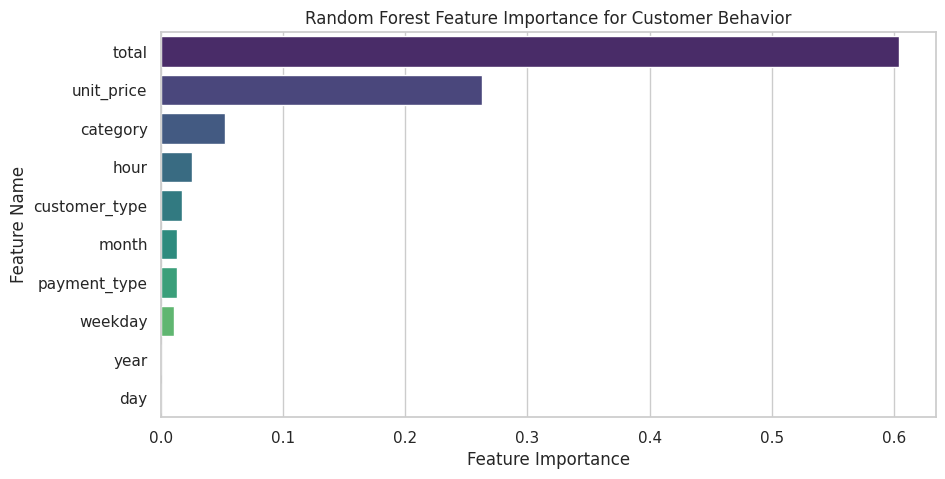

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names (if X_train is a DataFrame)
feature_names = X_train.columns

# Extract feature importances from Random Forest
feature_importances = rf_model.feature_importances_

# Convert to DataFrame
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importance for Customer Behavior")
plt.show()


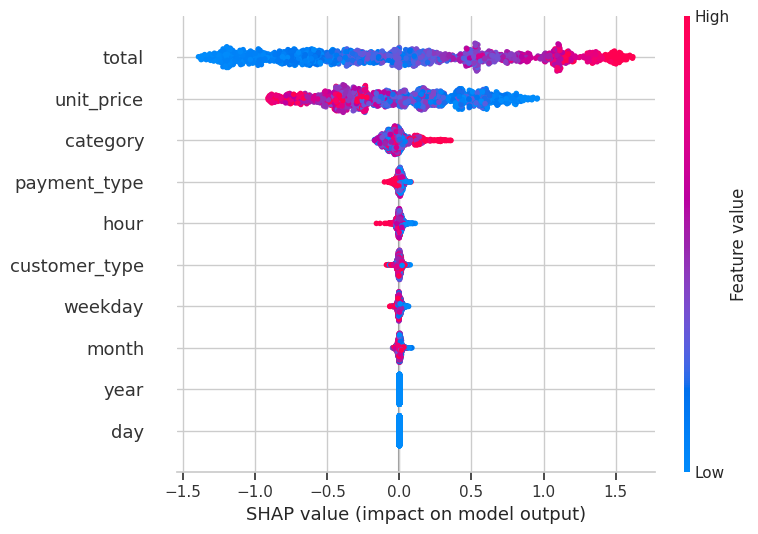

In [ ]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)
